In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

from tqdm.notebook import tqdm
from collections import Counter
import random

In [2]:
def read_dataset_internal(name):
    contents = pd.read_csv(name)
    X = contents.drop("y", axis=1)
    Y = contents["y"]
    return (X.values, Y.values)

def read_dataset(n, part):
    name = "data/"
    if n < 10:
        name += "0"
    name += str(n) + "_" + part + ".csv"
    return read_dataset_internal(name)

def read_all_datasets():
    data = []
    for i in range(1, 22):
        data.append({
            "test": read_dataset(i, "test"),
            "train": read_dataset(i, "train"),
            "name": str(i)
        })
    return data

In [3]:
data = read_all_datasets()

In [4]:
def get_params_for_tree():
    p = []
    for cr in ["gini", "entropy"]:
        for s in ["best", "random"]:
            for h in range(1, 30):
                p.append({
                    "crit": cr,
                    "split": s,
                    "height": h
                })
    return p

def get_params_for_forest():
    p = []
    for cr in ["gini", "entropy"]:
        for s in ["best", "random"]:
            p.append({
                "crit": cr,
                "split": s,
            })
    return p

In [5]:
def get_model(X, Y, params):
    clf = DecisionTreeClassifier(
        criterion=params["crit"], 
        splitter=params["split"], 
        max_depth=params["height"]
    )
    clf.fit(X, Y)
    return clf

def get_model_for_forest(X, Y, params):
    clf = DecisionTreeClassifier(
        criterion=params["crit"], 
        splitter=params["split"], 
        max_features="sqrt"
    )
    clf.fit(X, Y)
    return clf

accuracy:0.9597130242825607


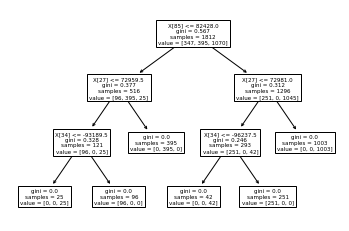

In [6]:
def see_tree(i, j):
    params = get_params_for_tree()
    m = get_model(data[i]["test"][0], data[i]["test"][1], params[j])
    print("accuracy:" + str(m.score(data[i]["train"][0], data[i]["train"][1])))
    plot_tree(m)

see_tree(5, 5)

In [7]:
# Tree

def tree():
    result = {}
    params = get_params_for_tree()
    for d in tqdm(data):
        for p in params:
            (X, Y) = d["train"]
            m = get_model(X, Y, p)
            (X, Y) = d["test"]
            acc = m.score(X, Y)
            if result.get(d["name"]) == None or result[d["name"]]["acc"] < acc:
                result[d["name"]] = {
                    "params": p,
                    "acc": acc
                }
    return result

In [8]:
def view_results(res):
    columns = []
    first_value = res[next(iter(res))]
    for p in first_value:
        if type(first_value[p]) is dict:
            for k in first_value[p].keys():
                columns.append(k)
        else:
            columns.append(p)
    data = []
    for r in res:
        next_data = []
        for i in res[r]:
            if type(res[r][i]) is dict:
                for k in res[r][i].values():
                    next_data.append(k)
            else:
                next_data.append(res[r][i])
        data.append(next_data)
    return pd.DataFrame(np.array(data), columns=columns, index=range(1, len(res) + 1))

In [9]:
best_for_tree = tree()

In [17]:
view_results(best_for_tree)

,crit,split,height,acc
1,entropy,best,3,0.9997429966589566
2,entropy,best,9,0.6994910941475827
3,gini,best,1,1.0
4,entropy,best,5,0.9951304347826087
5,gini,best,1,0.9956709956709957
6,entropy,best,3,0.9988962472406181
7,entropy,best,3,0.9967441860465116
8,gini,best,2,0.997920997920998
9,entropy,best,5,0.8568627450980392
10,entropy,best,4,0.9979879275653923


Min height in dataset №3
{'params': {'crit': 'gini', 'split': 'best', 'height': 1}, 'acc': 1.0}


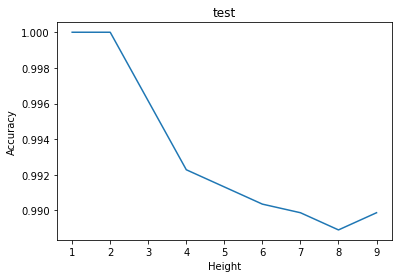

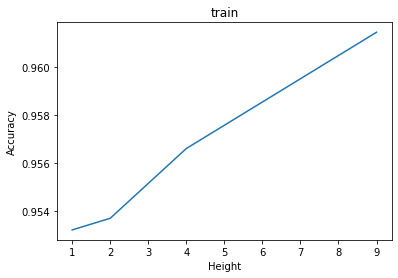

Max height in dataset №2
{'params': {'crit': 'entropy', 'split': 'best', 'height': 9}, 'acc': 0.6994910941475827}


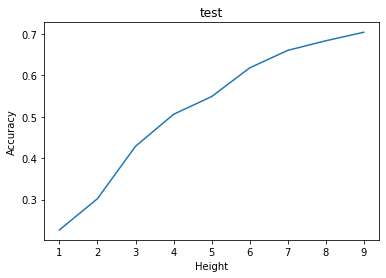

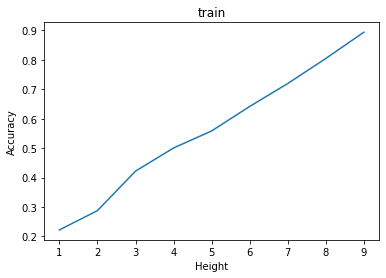

In [21]:
# Plots

def get_h(i):
    return best_for_tree[i]["params"]["height"]

def accuracy_by_height(ind, r, title):
    plt.xlabel("Height")
    plt.ylabel("Accuracy")
    v = []
    plt.title(title)
    for h in r:
        p = best_for_tree[ind]["params"].copy()
        p["height"] = h
        
        d = data[int(ind) - 1]
        (X, Y) = d["train"]
        m = get_model(X, Y, p)
        
        (X, Y) = d[title]
        v.append(m.score(X, Y))
    plt.plot(r, v)
    plt.show()
    
min_h_ind = "1"
max_h_ind = "1"
for r in best_for_tree:
    if get_h(r) < get_h(min_h_ind):
        min_h_ind = r
    if get_h(r) > get_h(max_h_ind):
        max_h_ind = r
r = range(int(get_h(min_h_ind)), int(get_h(max_h_ind)) + 1)
print("Min height in dataset №" + min_h_ind)
print(best_for_tree[min_h_ind])
accuracy_by_height(min_h_ind, r, "test")
accuracy_by_height(min_h_ind, r, "train")
print("Max height in dataset №" + max_h_ind)
print(best_for_tree[max_h_ind])
accuracy_by_height(max_h_ind, r, "test")
accuracy_by_height(max_h_ind, r, "train")

In [12]:
# Forest

def get_random_sample(X, Y):
    n = len(X)
    new_X = []
    new_Y = []
    for i in range(n):
        ind = random.randint(0, n - 1)
        new_X.append(X[ind])
        new_Y.append(Y[ind])
    return (np.array(new_X), np.array(new_Y))

def most_frequent(l): 
    return Counter(l).most_common(1)[0][0]

def get_score(Y, P):
    Y_P = []
    for i in range(len(Y)):
        Y_P.append(most_frequent([p[i] for p in P]))
    return accuracy_score(Y, Y_P);

def forest():
    result = {}
    params = get_params_for_forest()
    for d in tqdm(data):
        p_test = []
        p_train = []
        result[d["name"]] = {}
        for i in range(1, 200):
            (X, Y) = d["train"]
            (X, Y) = get_random_sample(X, Y)
            
            p = params[random.randint(0, len(params) - 1)]
            m = get_model_for_forest(X, Y, p)
            
            (X, _) = d["train"]
            p_train.append(m.predict(X))
            (X, _) = d["test"]
            p_test.append(m.predict(X))

        (_, Y) = d["train"]
        result[d["name"]]["accuracy_on_train"] = get_score(Y, p_train)
        
        (_, Y) = d["test"]
        result[d["name"]]["accuracy_on_test"] = get_score(Y, p_test)
    return result

In [13]:
view_results(forest())

KeyboardInterrupt: 